# Training NN models:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.cluster import MiniBatchKMeans
import joblib
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from DataGenerator import DataGenerator_Sup
from utility_functions import plot_confusion_matrix, create_model

Using TensorFlow backend.


Get a list of all files:

In [2]:
Ad_folder = '../Data/audio_ads' # positive samples location
Music_folder = '../Data/Music'  # negative samples (music) location
Podcast_folder = '../Data/pod'  # negative samples (podcasts) location

pos_files = []
for r,d,f in os.walk(Ad_folder):
    for filename in f:
        if '.mp3' in filename:
            pos_files.append(os.path.join(Ad_folder,filename))

music_files = []
for r,d,f in os.walk(Music_folder):
    for filename in f:
        if '.mp3' or '.au' in filename:
            music_files.append(os.path.join(r,filename))

podcast_files = []
for r,d,f in os.walk(Podcast_folder):
    for filename in f:
        if '.wav' in filename:
            podcast_files.append(os.path.join(r,filename))


How many mp3 files do we have?

In [3]:
neg_files = music_files + podcast_files
n_pos_files = len(pos_files)
n_neg_files = len(neg_files)

print('We have ' + str(n_pos_files) + ' positive examples')
print('We have ' + str(len(music_files)) + ' music examples')
print('We have ' + str(len(podcast_files)) + ' podcast examples')

music_duration = 30/60.0 # duration of files in minutes
podcast_duration = 12/60.0 # duration of files in minutes
ads_duration = 30/60.0 # average duration of ad files in minutes

pos_minutes = round(ads_duration*n_pos_files,2)
neg_minutes = round(music_duration*len(music_files) + podcast_duration*len(podcast_files),2)
pos_fraction = str(round(neg_minutes/pos_minutes,2)) # the fraction of positives to take for balancing
print('--------------------------------')
print('In total, ' + str(pos_minutes) + ' minutes of positive and ' + str(neg_minutes) + ' minutes of negative')

We have 2303 positive examples
We have 1023 music examples
We have 1567 podcast examples
--------------------------------
In total, 1151.5 minutes of positive and 824.9 minutes of negative


### Create data generators:

#### Decide which part of the data to use and how data will be distributed:

In [4]:
minutes2use = 1000 # total minutes to use for training and testing
train_fraction = 0.9 # fraction of the data to train on

pos_minutes2use = int(minutes2use/2.0)
neg_minutes2use = int(minutes2use/2.0)

music_minutes2use = (neg_minutes2use/2)*2
podcast_minutes2use = (neg_minutes2use/2)*0
assert music_minutes2use + podcast_minutes2use == neg_minutes2use, 'music + podcast != neg'

# calculate train and test minutes splitting
# train
pos_train_minutes = round(train_fraction*pos_minutes2use, 2) # number of pos audio training minutes
music_train_minutes = round(train_fraction*music_minutes2use, 2) # number of minutes for music training
podcast_train_minutes = round(train_fraction*podcast_minutes2use, 2) # number of minutes for podcast training
# test
pos_test_minutes = pos_minutes2use - pos_train_minutes
music_test_minutes = music_minutes2use - music_train_minutes
if podcast_minutes2use:
    podcast_test_minutes = podcast_minutes2use - podcast_train_minutes
else:
    podcast_test_minutes = 0

print('Using ' + str(pos_train_minutes) + ' minutes of positives for training and '
      + str(pos_test_minutes) + ' for testing')
print('Using ' + str(music_train_minutes) + ' minutes of music and ' 
      + str(podcast_train_minutes) +' minutes of podcasts for training')
print('Using ' + str(music_test_minutes) + ' minutes of music and ' 
      + str(podcast_test_minutes) +' minutes of podcasts for testing')

# calculate number of files
# train
n_music_train_files = int(music_train_minutes/music_duration)
n_podcast_train_files = int(podcast_train_minutes/podcast_duration)
n_pos_train_files = int(pos_train_minutes/ads_duration)
# test
n_music_test_files = int(music_test_minutes/music_duration)
n_podcast_test_files = int(podcast_test_minutes/podcast_duration)
n_pos_test_files = int(pos_test_minutes/ads_duration)
print('---------------------------------------------------------------')
print('This translates into:')
print( str(n_music_train_files) + ' files of music' + ' and ' 
      + str(n_podcast_train_files) + ' files of podcasts for training')
print( str(n_music_test_files) + ' files of music' + ' and ' 
      + str(n_podcast_test_files) + ' files of podcasts for testing')
print(str(n_pos_train_files) + ' poitive files for training')
print(str(n_pos_test_files) + ' poitive files for testing')

assert len(music_files) >= n_music_train_files + \
n_music_test_files, 'There are not enough music files for that!'
assert len(podcast_files) >= n_podcast_train_files + \
n_podcast_test_files, 'There are not enough podcast files for that!'

Using 450.0 minutes of positives for training and 50.0 for testing
Using 450.0 minutes of music and 0.0 minutes of podcasts for training
Using 50.0 minutes of music and 0 minutes of podcasts for testing
---------------------------------------------------------------
This translates into:
900 files of music and 0 files of podcasts for training
100 files of music and 0 files of podcasts for testing
900 poitive files for training
100 poitive files for testing


#### Create a generator based on the above:

In [5]:
train_files = [] # a list of training files 
test_files = [] # a list of test files 

# shuffle files
np.random.seed(1)
np.random.shuffle(pos_files)
np.random.seed(2)
np.random.shuffle(music_files)
np.random.seed(3)
np.random.shuffle(podcast_files)

'''Collect a balanced list of files + add labels'''
# Training list
for f in pos_files[:n_pos_train_files]:
    train_files.append([f,1])
for f in music_files[:n_music_train_files]:
    train_files.append([f,0])
for f in podcast_files[:n_podcast_train_files]:
    train_files.append([f,0])

# Test list
for f in pos_files[n_pos_train_files:n_pos_train_files + n_pos_test_files]:
    test_files.append([f,1])
for f in music_files[n_music_train_files:n_music_train_files + n_music_test_files]:
    test_files.append([f,0])
for f in podcast_files[n_podcast_train_files:n_podcast_train_files + n_podcast_test_files]:
    test_files.append([f,0])

train_generator = DataGenerator_Sup(train_files, dataset='train')
test_generator = DataGenerator_Sup(test_files, dataset='test')

Check generators:

In [6]:
len(train_generator)

180

In [7]:
len(test_generator)

20

In [8]:
if 1:
    X, Y = train_generator.__getitem__(1) # get item
    print(X.shape)
    print(Y.shape)
    print('Positive example fraction in batch is ' + str((sum(Y == 1)/Y.shape[0])[0]))

(125, 1690)
(125, 1)
Positive example fraction in batch is 0.84


### Train NN model:

Create and compile model:

In [10]:
model = create_model()
filepath = 'models/weights_1690_256_64_1_1000minutes_only_music_and_ads.hdf5'
checkpoint = ModelCheckpoint(filepath)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               432896    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 449,409
Trainable params: 449,409
Non-trainable params: 0
_________________________________________________________________


Train model:

In [11]:
H = model.fit_generator(generator = train_generator, epochs = 10, callbacks = [checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
180/180 [==============================] - 2618s 15s/step - loss: 0.3026 - acc: 0.8743
Epoch 2/10
180/180 [==============================] - 2414s 13s/step - loss: 0.2416 - acc: 0.8992
Epoch 3/10
180/180 [==============================] - 2372s 13s/step - loss: 0.1840 - acc: 0.9297
Epoch 4/10
180/180 [==============================] - 2451s 14s/step - loss: 0.1666 - acc: 0.9352
Epoch 5/10
180/180 [==============================] - 2266s 13s/step - loss: 0.1401 - acc: 0.9470
Epoch 6/10
180/180 [==============================] - 2359s 13s/step - loss: 0.1349 - acc: 0.9512
Epoch 7/10
180/180 [==============================] - 2480s 14s/step - loss: 0.1225 - acc: 0.9572
Epoch 8/10
180/180 [==============================] - 2342s 13s/step - loss: 0.1088 - acc: 0.9585
Epoch 9/10
180/180 [==============================] - 2361s 13s/step - loss: 0.0896 - acc: 0.9683
Epoch 10/10
180/180 [==============================] - 2485s 14s/step 

Text(0.5, 0, 'epoch')

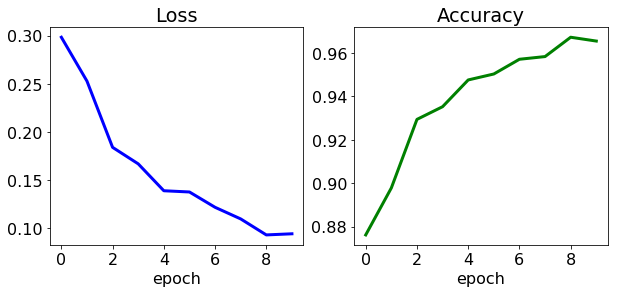

In [12]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize= (10,4))
plt.subplot(1,2,1)
plt.plot(H.history['loss'], linewidth=3, color = 'b')
plt.title('Loss')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(H.history['acc'], linewidth=3, color = 'g')
plt.title('Accuracy')
plt.xlabel('epoch')

In [13]:
# Error files:
train_generator.err_files

[]

### Check Accuracy:

In [14]:
filepath = 'models/weights_1690_256_64_1_1000minutes_only_music_and_ads.hdf5'
# recreate a model for evaluation
eval_model = create_model()
# load weights
eval_model.load_weights(filepath)
# compile
eval_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               432896    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 449,409
Trainable params: 449,409
Non-trainable params: 0
_________________________________________________________________


What metrics do we use for evaluation?

In [15]:
eval_model.metrics_names

['loss', 'acc']

How does the model perform on the test?

In [ ]:
eval_model.evaluate_generator(generator = test_generator, steps = 2)

Plot confusion matrix:

In [ ]:
X,Y = test_generator.__getitem__(3)
Y_pred = eval_model.predict(X)

In [ ]:
plot_confusion_matrix(Y, Y_pred>0.9, ['Non Ad', 'Ad'])

In [ ]:
sum(Y)

In [ ]:
len(test_genrator)